In [1]:
from src import *

# 🗺️ Major-TOM Filtering
[![HF](https://img.shields.io/badge/%F0%9F%A4%97-Datasets-yellow)](https://www.huggingface.co/Major-TOM) [![paper](https://img.shields.io/badge/arXiv-2402.12095-D12424)](https://www.arxiv.org/abs/2402.12095) [![GitHub stars](https://img.shields.io/github/stars/ESA-PhiLab/Major-TOM?style=social&label=Star&maxAge=2592000)](https://github.com/ESA-PhiLab/Major-TOM/)

This notebook demonstrates how to access MajorTOM-Core-S2L2A data quickly and filter a subset of interest.

Examples:
1. Filtering based on location, time, and cloud cover
2. Downloading a filtered subset of the dataset
3. PyTorch Dataset with a local copy
4. HuggingFace `datasets` fast access via streaming

### 1. 📅 Filtering based on location, time, and cloud cover
First we will download a local copy of the dataset metadata, in this case from `Major-TOM/Core-S2L2a`

In [2]:
from pathlib import Path
import urllib.request

SOURCE_DATASET = 'Major-TOM/Core-S2L2A' # Identify HF Dataset
DATASET_DIR = Path('./data/Major-TOM/')
DATASET_DIR.mkdir(exist_ok=True, parents=True)
ACCESS_URL = 'https://huggingface.co/datasets/{}/resolve/main/metadata.parquet?download=true'.format(SOURCE_DATASET)
LOCAL_URL = DATASET_DIR / '{}.parquet'.format(ACCESS_URL.split('.parquet')[0].split('/')[-1])

# download from server to local url
gdf = metadata_from_url(ACCESS_URL, LOCAL_URL)

gdf.head()

,grid_cell,grid_row_u,grid_col_r,product_id,timestamp,cloud_cover,nodata,centre_lat,centre_lon,crs,parquet_url,parquet_row,geometry
0,922D_249L,-922,-249,S2A_MSIL2A_20230119T161811_N0509_R111_T01CDJ_2...,2023-01-19 16:18:11,18.941737,0.0,-82.770666,-178.200331,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,0,POINT (-178.200 -82.771)
1,922D_245L,-922,-245,S2B_MSIL2A_20181219T162339_N9999_R011_T01CEJ_2...,2018-12-19 16:23:39,22.742201,0.0,-82.768451,-175.349546,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,1,POINT (-175.350 -82.768)
2,922D_244L,-922,-244,S2A_MSIL2A_20200119T155811_N9999_R025_T01CEJ_2...,2020-01-19 15:58:11,0.000000,0.0,-82.767914,-174.636985,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,2,POINT (-174.637 -82.768)
3,922D_243L,-922,-243,S2A_MSIL2A_20210103T155811_N9999_R025_T01CEJ_2...,2021-01-03 15:58:11,3.769691,0.0,-82.767385,-173.924477,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,3,POINT (-173.924 -82.767)
4,922D_242L,-922,-242,S2B_MSIL2A_20181220T155319_N9999_R025_T01CEJ_2...,2018-12-20 15:53:19,0.000000,0.0,-82.766864,-173.212021,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,4,POINT (-173.212 -82.767)


Then, we can specify a few regions using shapely geometry, for example:

In [3]:
from shapely.geometry import box

# Example bounding boxes used for filtering
switzerland = box(5.9559111595,45.8179931641,10.4920501709,47.808380127)
gabon = box(8.1283659854,-4.9213919841,15.1618722208,2.7923006325)
napoli = box(14.091710578,40.7915558593,14.3723765416,40.9819258062)
pacific = box(-153.3922893485,39.6170415622,-152.0423077748,40.7090892316) # a remote patch over pacific - no data

and then use it via our `filter_metadata` function - let's try to get some recent images around ⚽🍕 Napoli!

In [4]:
filtered_df = filter_metadata(gdf,
                              cloud_cover = (0,10), # cloud cover between 0% and 10%
                              region=napoli, # you can try with different bounding boxes, like in the cell above
                              daterange=('2020-01-01', '2025-01-01'), # temporal range
                              nodata=(0.0,0.0) # only 0% of no data allowed
                              )

filtered_df.head()

,grid_cell,grid_row_u,grid_col_r,product_id,timestamp,cloud_cover,nodata,centre_lat,centre_lon,crs,parquet_url,parquet_row,geometry
1593374,454U_120R,454,120,S2B_MSIL2A_20220719T095559_N0400_R122_T33TVF_2...,2022-07-19 09:55:59,0.0,0.0,40.823861,14.292709,EPSG:32633,https://huggingface.co/datasets/Major-TOM/Core...,455,POINT (14.293 40.824)
1595266,455U_120R,455,120,S2B_MSIL2A_20220719T095559_N0400_R122_T33TVF_2...,2022-07-19 09:55:59,0.0,0.0,40.913671,14.311585,EPSG:32633,https://huggingface.co/datasets/Major-TOM/Core...,347,POINT (14.312 40.914)
1595265,455U_119R,455,119,S2A_MSIL2A_20200113T095351_N0500_R079_T33TVF_2...,2020-01-13 09:53:51,0.0,0.0,40.913731,14.192730,EPSG:32633,https://huggingface.co/datasets/Major-TOM/Core...,346,POINT (14.193 40.914)


Any row from the metadata can be very easily read into a `dict` of numpy arrays using our `read_row` function:

In [5]:
out = read_row(filtered_df.iloc[0], columns = ['B04', 'thumbnail'])

/home/mczerkawski/mambaforge/envs/miko-torch/lib/python3.8/site-packages/fsspec/parquet.py:225: UserWarning: Not enough data was used to sample the parquet footer. Try setting footer_sample_size >= 1031336.
  warnings.warn(


### 📩 Downloading a filtered subset of the dataset

Use the `filter_download` function to download all files to the local directory at `local_dir`. Your new dataset will be named using `source_name`.

More importantly, the `by_row` option allows to download specific rows from the archives. Set it to `True`, if you think you will take only a few files from each parquet file (most parquet files contain samples that are close to each other in space).

If you expect to take most of the samples from the parquet file, setting `by_row` to `False` will probably be quicker (you then download the data as the entire file, before you rearrange it onto folders with only the files from your dataframe).

In [6]:
filter_download(filtered_df, local_dir='./data/', source_name='L2A', by_row=True)

You can now check your local directory for the local version of your dataset!

### 🔥 PyTorch Dataset with a local copy
We can use it directly with our `PyTorch` definition of the Dataset `MajorTOM`, just supply the metadata file and teh directory of the files:

In [7]:
ds = MajorTOM(filtered_df, './data/L2A')

ds[0]

{'meta': grid_cell                                              454U_120R
 grid_row_u                                                   454
 grid_col_r                                                   120
 product_id     S2B_MSIL2A_20220719T095559_N0400_R122_T33TVF_2...
 timestamp                                    2022-07-19 09:55:59
 cloud_cover                                                  0.0
 nodata                                                       0.0
 centre_lat                                             40.823861
 centre_lon                                             14.292709
 crs                                                   EPSG:32633
 parquet_url    https://huggingface.co/datasets/Major-TOM/Core...
 parquet_row                                                  455
 geometry             POINT (14.29270867998482 40.82386055223662)
 Name: 1593374, dtype: object,
 'B04': array([[[1563, 1437, 1466, ..., 2152, 2128, 2482],
         [1463, 1468, 1722, ..., 2418, 2334,

### Ecco!

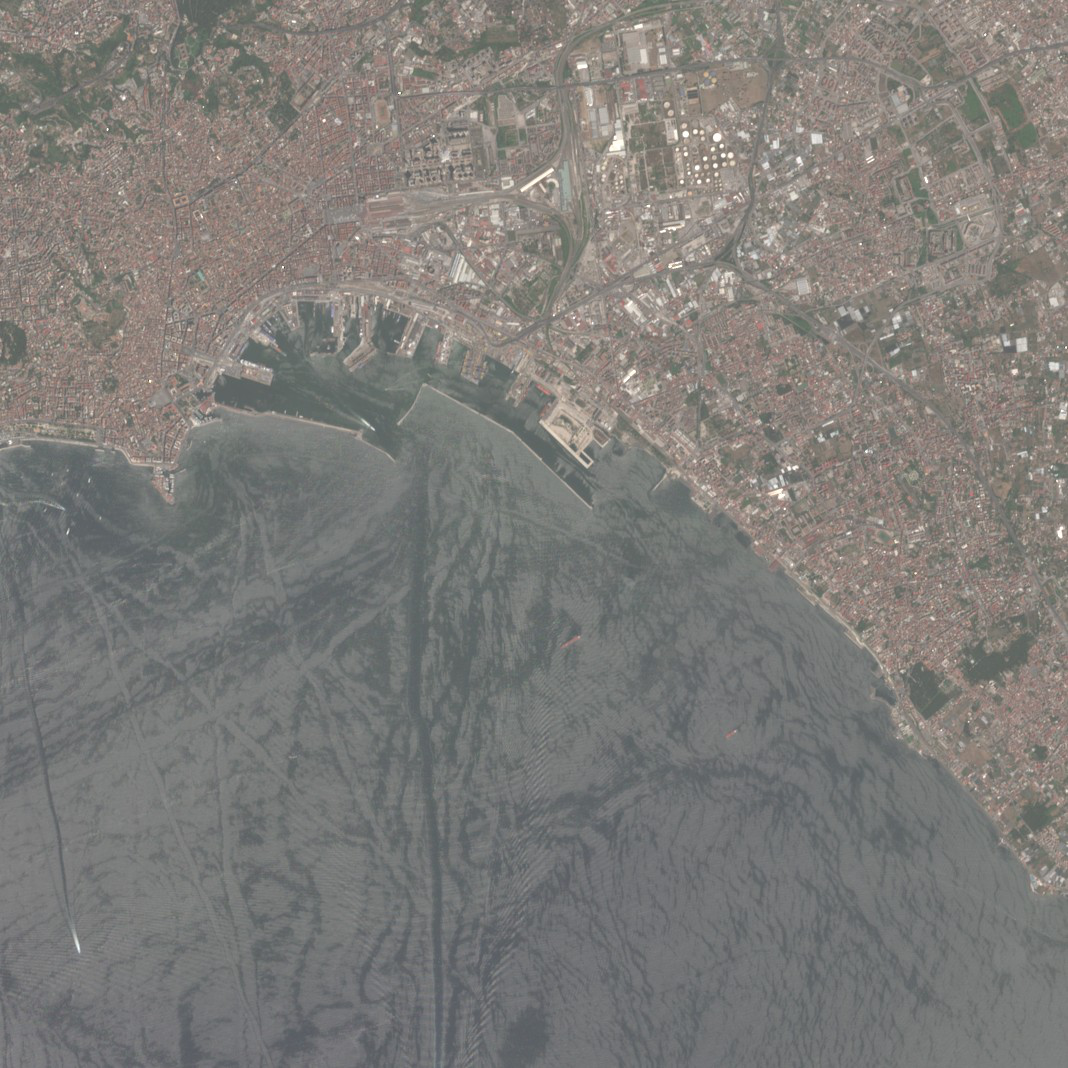

In [8]:
ds[0]['thumbnail']

### HuggingFace `datasets` fast access via streaming
First let's start with an example of very quick access *without* any filtering using HuggingFace `datasets` library with `streaming=True` functionality:

In [9]:
import datasets

ds = datasets.load_dataset('Major-TOM/Core-S2L2A', streaming=True)['train']

Resolving data files:   0%|          | 0/4492 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/4492 [00:00<?, ?it/s]

In [10]:
sample = next(iter(ds))

> Note that the first few thousand samples are near the South pole, so they tend to be quite bright! You can recover more information from the original tif files!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


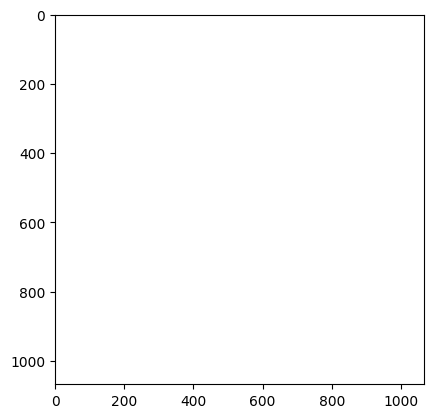

In [11]:
plot(sample)

## Alternative: Filter by points : 🌋 MajorTOM-Volcano
In case you are interested in retrieving all Major-TOM samples that contain specific points of interest, you can also use the `filter_metadata` in an alternative way.

First, let's use an example data that contains multiple points with reference latitude and longitude coordinates (here, we focus on volcanoes):

In [12]:
import pandas as pd

# Volcano example database from plotly - hopefully you can still access the file at the time of use
query_df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/volcano_db.csv', encoding="ISO-8859-1")

query_df.head()

,Number,Volcano Name,Country,Region,Latitude,Longitude,Elev,Type,Status,Last Known
0,0803-001,Abu,Japan,Honshu-Japan,34.500,131.600,571.0,Shield volcano,Holocene,Unknown
1,1505-096,Acamarachi,Chile,Chile-N,-23.300,-67.620,6046.0,Stratovolcano,Holocene,Unknown
2,1402-08=,Acatenango,Guatemala,Guatemala,14.501,-90.876,3976.0,Stratovolcano,Historical,D1
3,0103-004,Acigol-Nevsehir,Turkey,Turkey,38.570,34.520,1689.0,Maar,Holocene,U
4,1201-04-,Adams,United States,US-Washington,46.206,-121.490,3742.0,Stratovolcano,Tephrochronology,D6


We can easily build a reference object of the Major-TOM grid to **transform these coordinates** to cells in Major-TOM grid:

In [13]:
from src.grid import *

# This might take a few seconds to initialise!
MT_grid = Grid(10) # 10 is the 10 km grid, which we use by default

We can use `latlon2rowcol` method to get the Major-TOM grid coordinates, and then append this information to our `query_df`, to effectively turn it into a Major-TOM dataset:

In [16]:
# Get rows and cols
rows,cols = MT_grid.latlon2rowcol(query_df.Latitude.tolist(),
                                  query_df.Longitude.tolist())

# Combine into a string '[]U_[]R'
points = ['{}_{}'.format(i,j) for i, j in zip(rows,cols)]

query_df['grid_cell'] = points
query_df.head()

,Number,Volcano Name,Country,Region,Latitude,Longitude,Elev,Type,Status,Last Known,grid_cell
0,0803-001,Abu,Japan,Honshu-Japan,34.500,131.600,571.0,Shield volcano,Holocene,Unknown,384U_1207R
1,1505-096,Acamarachi,Chile,Chile-N,-23.300,-67.620,6046.0,Stratovolcano,Holocene,Unknown,260D_692L
2,1402-08=,Acatenango,Guatemala,Guatemala,14.501,-90.876,3976.0,Stratovolcano,Historical,D1,161U_980L
3,0103-004,Acigol-Nevsehir,Turkey,Turkey,38.570,34.520,1689.0,Maar,Holocene,U,429U_300R
4,1201-04-,Adams,United States,US-Washington,46.206,-121.490,3742.0,Stratovolcano,Tephrochronology,D6,514U_937L


We can also filter the Major-TOM metadata file to reduce it only to the relevant samples:

In [17]:
filtered_df = gdf[gdf.grid_cell.isin(points)]
filtered_df.head()

,grid_cell,grid_row_u,grid_col_r,product_id,timestamp,cloud_cover,nodata,centre_lat,centre_lon,crs,parquet_url,parquet_row,geometry
8582,874D_362R,-874,362,S2B_MSIL2A_20211009T203629_N0500_R085_T58CDT_2...,2021-10-09 20:36:29,0.000000,0.000000,-78.459578,163.334896,EPSG:32758,https://huggingface.co/datasets/Major-TOM/Core...,82,POINT (163.335 -78.460)
9066,872D_369R,-872,369,S2B_MSIL2A_20190217T194529_N9999_R013_T58CDU_2...,2019-02-17 19:45:29,0.330872,0.043524,-78.279551,163.821772,EPSG:32758,https://huggingface.co/datasets/Major-TOM/Core...,66,POINT (163.822 -78.280)
11252,864D_399R,-864,399,S2B_MSIL2A_20221011T202619_N0400_R042_T58CEU_2...,2022-10-11 20:26:19,1.743081,0.000000,-77.558538,167.030580,EPSG:32758,https://huggingface.co/datasets/Major-TOM/Core...,252,POINT (167.031 -77.559)
12276,860D_312L,-860,-312,S2B_MSIL2A_20191022T161349_N0500_R111_T09CWQ_2...,2019-10-22 16:13:49,12.105567,0.000000,-77.199072,-126.720404,EPSG:32709,https://huggingface.co/datasets/Major-TOM/Core...,276,POINT (-126.720 -77.199)
13820,856D_412R,-856,412,S2B_MSIL2A_20210201T203629_N0500_R085_T58CDV_2...,2021-02-01 20:36:29,0.000000,0.000000,-76.842900,163.192393,EPSG:32758,https://huggingface.co/datasets/Major-TOM/Core...,320,POINT (163.192 -76.843)


Finally, we can now explore some samples of interest, like below:

/home/mczerkawski/mambaforge/envs/miko-torch/lib/python3.8/site-packages/fsspec/parquet.py:225: UserWarning: Not enough data was used to sample the parquet footer. Try setting footer_sample_size >= 1033166.
  warnings.warn(


Number                0803-001
Volcano Name               Abu
Country                  Japan
Region            Honshu-Japan
Latitude                  34.5
Longitude                131.6
Elev                     571.0
Type            Shield volcano
Status                Holocene
Last Known             Unknown
grid_cell           384U_1207R
Name: 0, dtype: object


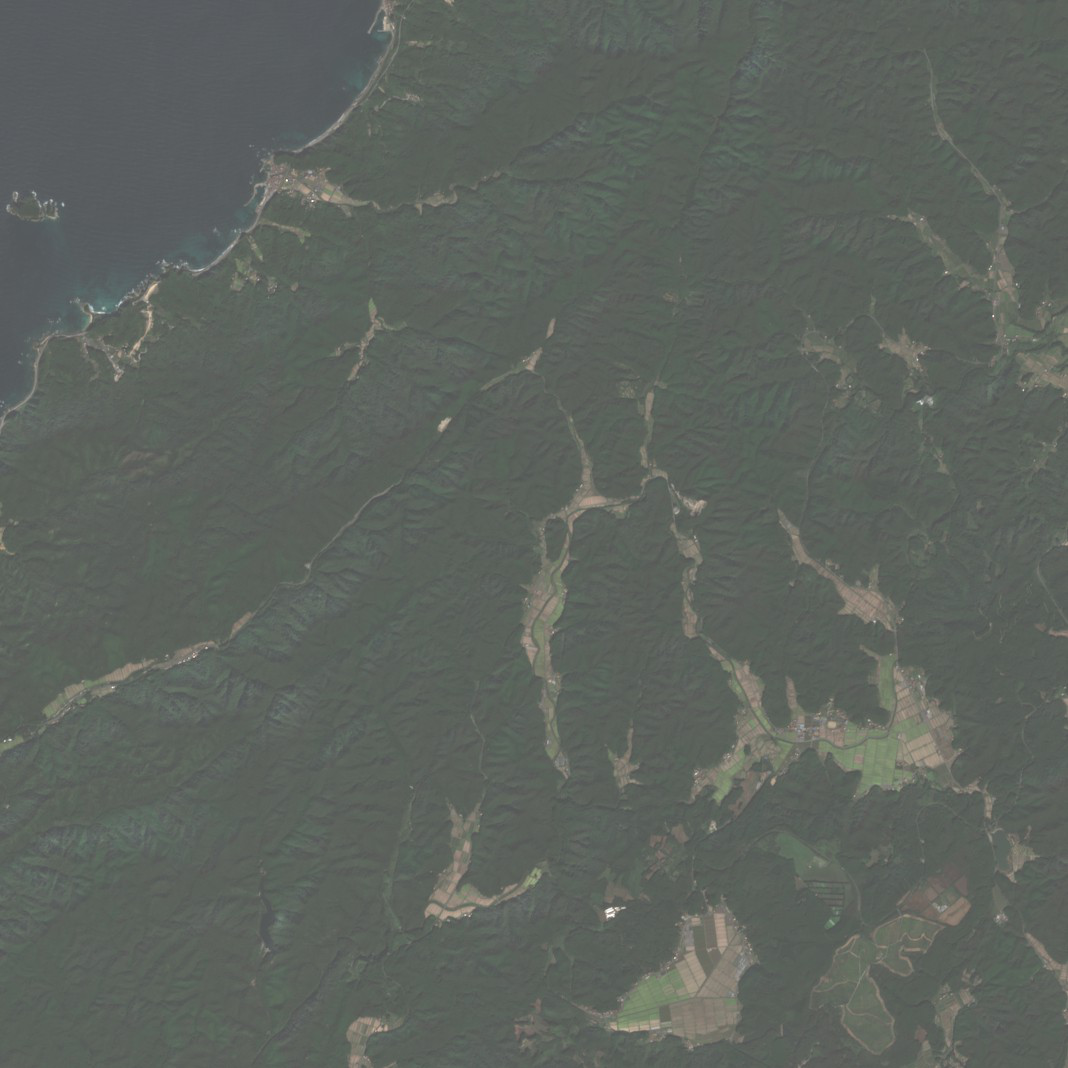

In [18]:
sample = query_df.iloc[0]

out = read_row(filtered_df[filtered_df.grid_cell==sample.grid_cell].iloc[0],
               columns = ['B04', 'thumbnail'])

print(sample)
out['thumbnail']

...and similarly to above, you can download a local copy of the Major-TOM dataset from a filtered dataframe:

In [ ]:
filter_download(filtered_df, local_dir='./data/', source_name='L2A', by_row=True)